# YouTube Spam Collection v. 1

## Grupo 2
Alberto Atilio Sbrana Junior
<br>
Luiz Barreto Pedro de Alcântara
<br>
Priscila Portela Costa

# Problema

Trata-se de um problema de classificação binária sobre comentários de vídeos no Youtube.
<br>
Há no total 5 arquivos, separados por artista:
- Psy
- Katy Perry
- LMFAO
- Eminem
- Shakira

# Bibliotecas

In [121]:
import pandas as pd
import numpy as np
import scipy.optimize
from ML_library import *
import matplotlib.pyplot as plt

# Modelo 4: Redes Neurais Artificiais

## Carregando os _datasets_

In [122]:
#occurency
X_occur_train = pd.read_csv('X_occurrency_train.csv', header=None)
X_occur_test = pd.read_csv('X_occurrency_test.csv', header=None)
X_occur_val = pd.read_csv('X_occurrency_validation.csv', header=None)

Y_occur_train = pd.read_csv('Y_occurrency_train.csv', header=None)
Y_occur_test = pd.read_csv('Y_occurrency_test.csv', header=None)
Y_occur_val = pd.read_csv('Y_occurrency_validation.csv', header=None)

#frequency
X_frequ_train = pd.read_csv('X_frequency_train.csv', header=None)
X_frequ_test = pd.read_csv('X_frequency_test.csv', header=None)
X_frequ_val = pd.read_csv('X_frequency_validation.csv', header=None)

Y_frequ_train = pd.read_csv('Y_frequency_train.csv', header=None)
Y_frequ_test = pd.read_csv('Y_frequency_test.csv', header=None)
Y_frequ_val = pd.read_csv('Y_frequency_validation.csv', header=None)

#tf_idf
X_tfidf_train = pd.read_csv('X_tfidf_train.csv', header=None)
X_tfidf_test = pd.read_csv('X_tfidf_test.csv', header=None)
X_tfidf_val = pd.read_csv('X_tfidf_validation.csv', header=None)

Y_tfidf_train = pd.read_csv('Y_tfidf_train.csv', header=None)
Y_tfidf_test = pd.read_csv('Y_tfidf_test.csv', header=None)
Y_tfidf_val = pd.read_csv('Y_tfidf_validation.csv', header=None)

## Funções auxiliares

In [123]:
def prep_Y(y):
    return np.array(y.values.flatten(), dtype = int)

#Normalização min-max
def min_max_scaler(x, scaler = None):
    if scaler == None:
        x_scaler = [x.min(), x.max()]
        x_scaled = (x - x.min()) / (x.max() - x.min())
        x_scaled.fillna(0, inplace = True)
        return x_scaler, x_scaled
    else:
        x_scaled = (x - scaler[0]) / (scaler[1] - scaler[0]).replace(0, np.inf)
        x_scaled = x_scaled.replace([np.inf, -np.inf], np.nan).fillna(0)
        return x_scaled
    
def inicializaPesosAleatorios(L_in, L_out, randomSeed = None):
    epsilon_init = 0.12
    if randomSeed is not None:
        W = np.random.RandomState(randomSeed).rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
    else:
        W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init     
    return W

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoidGradient(z):
    return sigmoid(z) * (1 - sigmoid(z))

def funcaoCusto_backp_reg(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, vLambda):
    
    Theta1 = np.reshape(nn_params[0:hidden_layer_size * (input_layer_size + 1)], 
                        (hidden_layer_size, input_layer_size + 1))
    Theta2 = np.reshape(nn_params[ hidden_layer_size * (input_layer_size + 1):], 
                        (num_labels, hidden_layer_size + 1))

    m = X.shape[0]
         
    J = 0;
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)

    Y = np.eye(num_labels)[y - 1]
    a1 = np.append(np.ones((m, 1)), X, axis = 1)
    a2 = np.append(np.ones((m, 1)), sigmoid(np.dot(a1, Theta1.T)), axis = 1)
    h = sigmoid(np.dot(a2, Theta2.T))
    J = - (1 / m) * np.sum(Y * np.log(h) + (1 - Y) * np.log(1 - h))
    
    T1 = np.sum(Theta1[:,1:] ** 2)
    T2 = np.sum(Theta2[:,1:] ** 2)

    J = J + (vLambda / (2 * m) * (T1 + T2))
    
    D1, D2 = 0, 0
    for i in range(m):
        x = X[i]
        a1 = np.append([1], x)
        a2 = np.append([1], sigmoid(np.dot(a1, Theta1.T)))
        a3 = sigmoid(np.dot(a2, Theta2.T))
        d3 = a3 - Y[i]
        d2 = np.dot(Theta2[:,1:].T, d3).T * sigmoidGradient(np.dot(a1, Theta1.T))
        D1 += np.outer(d2, a1)
        D2 += np.outer(d3, a2)
    
    Theta1_grad = D1 / m
    Theta2_grad = D2 / m
    
    Theta1_1st_j = np.copy(Theta1_grad[:,0])
    Theta2_1st_j = np.copy(Theta2_grad[:,0])
    Theta1_grad += vLambda / m * Theta1
    Theta2_grad += vLambda / m * Theta2
    Theta1_grad[:,0] = Theta1_1st_j
    Theta2_grad[:,0] = Theta2_1st_j
    
    grad = np.concatenate([np.ravel(Theta1_grad), np.ravel(Theta2_grad)])

    return J, grad

def predicao(Theta1, Theta2, X):
    m = X.shape[0]
    num_labels = Theta2.shape[0]

    a1 = np.hstack([np.ones([m, 1]), X])
    h1 = sigmoid(np.dot(a1, Theta1.T))

    a2 = np.hstack([np.ones([m, 1]), h1]) 
    h2 = sigmoid(np.dot(a2, Theta2.T))
    
    p = np.argmax(h2, axis=1)
    
    return p

## Hiperparâmetros

In [124]:
#Hiper-parâmetros
hidden_layer_size = 25
num_labels = 2
vLambda = 1
MaxIter = 200

## Occurrency

In [125]:
Y_occur_train, Y_occur_val = prep_Y(Y_occur_train), prep_Y(Y_occur_val)    

X_occur_scaler, X_train_occur_scaled = min_max_scaler(X_occur_train)
X_val_occur_scaled = min_max_scaler(X_occur_val, X_occur_scaler)
X_train_occur_scaled, X_val_occur_scaled = X_train_occur_scaled.values, X_val_occur_scaled.values

In [126]:
#Iniciar Thetas
input_layer_size  = X_train_occur_scaled.shape[1]
Theta1 = inicializaPesosAleatorios(input_layer_size, hidden_layer_size, randomSeed = 10)
Theta2 = inicializaPesosAleatorios(hidden_layer_size, num_labels, randomSeed = 20)
nn_params = np.concatenate([np.ravel(Theta1), np.ravel(Theta2)])

In [127]:
#Rodar modelo
args = (input_layer_size, hidden_layer_size, num_labels, X_train_occur_scaled, Y_occur_train + 1, vLambda)

result = scipy.optimize.minimize(fun=funcaoCusto_backp_reg, x0=nn_params, args=args,
                                 method='TNC', jac=True, options={'maxiter':MaxIter})

nn_params = result.x
Theta1 = np.reshape(nn_params[0:hidden_layer_size * (input_layer_size + 1)], 
                    (hidden_layer_size, input_layer_size + 1))
Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], 
                    (num_labels, hidden_layer_size + 1))

In [128]:
#Gerar predição
pred_occur = predicao(Theta1, Theta2, X_val_occur_scaled)
cm_occur = get_confusionMatrix(Y_occur_val, pred_occur, [0,1])

print('Matriz de confusão:')
print(cm_occur)

Matriz de confusão:
[[126  23]
 [ 19  99]]


## Frequency

In [129]:
Y_frequ_train, Y_frequ_val = prep_Y(Y_frequ_train), prep_Y(Y_frequ_val)    

X_frequ_scaler, X_train_frequ_scaled = min_max_scaler(X_frequ_train)
X_val_frequ_scaled = min_max_scaler(X_frequ_val, X_frequ_scaler)
X_train_frequ_scaled, X_val_frequ_scaled = X_train_frequ_scaled.values, X_val_frequ_scaled.values

In [130]:
#Iniciar Thetas
input_layer_size  = X_train_frequ_scaled.shape[1]
Theta1 = inicializaPesosAleatorios(input_layer_size, hidden_layer_size, randomSeed = 10)
Theta2 = inicializaPesosAleatorios(hidden_layer_size, num_labels, randomSeed = 20)
nn_params = np.concatenate([np.ravel(Theta1), np.ravel(Theta2)])

In [131]:
#Rodar modelo
args = (input_layer_size, hidden_layer_size, num_labels, X_train_frequ_scaled, Y_frequ_train + 1, vLambda)

result = scipy.optimize.minimize(fun=funcaoCusto_backp_reg, x0=nn_params, args=args,
                                 method='TNC', jac=True, options={'maxiter':MaxIter})

nn_params = result.x
Theta1 = np.reshape(nn_params[0:hidden_layer_size * (input_layer_size + 1)], 
                    (hidden_layer_size, input_layer_size + 1))
Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], 
                    (num_labels, hidden_layer_size + 1))

In [132]:
#Gerar predição
pred_frequ = predicao(Theta1, Theta2, X_val_frequ_scaled)
cm_frequ = get_confusionMatrix(Y_frequ_val, pred_frequ, [0,1])

print('Matriz de confusão:')
print(cm_frequ)

Matriz de confusão:
[[124  25]
 [ 24  94]]


## TF-IDF

In [133]:
Y_tfidf_train, Y_tfidf_val = prep_Y(Y_tfidf_train), prep_Y(Y_tfidf_val)    

X_tfidf_scaler, X_train_tfidf_scaled = min_max_scaler(X_tfidf_train)
X_val_tfidf_scaled = min_max_scaler(X_tfidf_val, X_tfidf_scaler)
X_train_tfidf_scaled, X_val_tfidf_scaled = X_train_tfidf_scaled.values, X_val_tfidf_scaled.values

In [134]:
#Iniciar Thetas
input_layer_size  = X_train_tfidf_scaled.shape[1]
Theta1 = inicializaPesosAleatorios(input_layer_size, hidden_layer_size, randomSeed = 10)
Theta2 = inicializaPesosAleatorios(hidden_layer_size, num_labels, randomSeed = 20)
nn_params = np.concatenate([np.ravel(Theta1), np.ravel(Theta2)])

In [135]:
#Rodar modelo
args = (input_layer_size, hidden_layer_size, num_labels, X_train_tfidf_scaled, Y_tfidf_train + 1, vLambda)
result = scipy.optimize.minimize(fun=funcaoCusto_backp_reg, x0=nn_params, args=args,
                                 method='TNC', jac=True, options={'maxiter':MaxIter})

nn_params = result.x
Theta1 = np.reshape(nn_params[0:hidden_layer_size * (input_layer_size + 1)], 
                    (hidden_layer_size, input_layer_size + 1))
Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], 
                    (num_labels, hidden_layer_size + 1))

In [136]:
#Gerar predição
pred_tfidf = predicao(Theta1, Theta2, X_val_tfidf_scaled)
cm_tfidf = get_confusionMatrix(Y_tfidf_val, pred_tfidf, [0,1])

print('Matriz de confusão:')
print(cm_tfidf)

Matriz de confusão:
[[126  23]
 [ 26  92]]


## F1 Scores

In [137]:
cm_nb = {'Occurrency': cm_occur,
         'Frequency': cm_frequ,
         'TF-IDF': cm_tfidf}

for k, cm in cm_nb.items():
    vp=cm[0,0] # quantidade de verdadeiros positivos
    vn=cm[1,1] # quantidade de verdadeiros negativos
    fp=cm[1,0] # quantidade de falsos positivos
    fn=cm[0,1] # quantidade de falsos negativos
    
    recall = vp/(vp+fn)
    precision = vp/(vp+fp)
    
    f1 = 2 * (precision * recall) / (precision + recall)
    print('Tratamento {}: {}'.format(k, f1))

Tratamento Occurrency: 0.8571428571428572
Tratamento Frequency: 0.8350168350168351
Tratamento TF-IDF: 0.8372093023255816


Verificamos que o modelo que usa o modo de tratamento _occurrency_ é o que se sai melhor de acordo com a métrica escolhida.

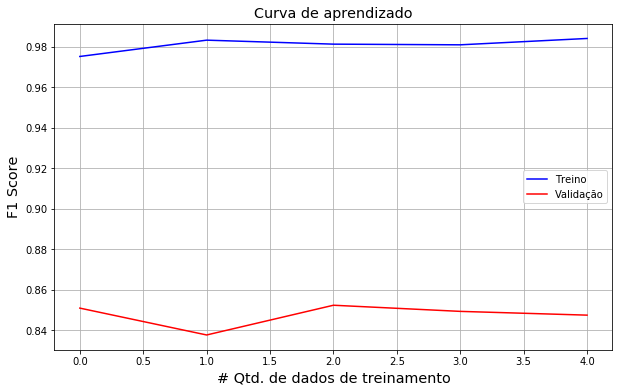

In [138]:
def curva_aprendizado_nn(X, Y, Xval, Yval):

    # inicializa as listas que guardarao a performance no treinamento e na validacao
    perf_train = []
    perf_val = []
    
    num_rows = len(X)
    
    for i in range(200,num_rows, 200):
        x_train = X[0:i,:]
        y_train = Y[0:i]
        
        #Iniciar Thetas
        input_layer_size  = x_train.shape[1]
        Theta1 = inicializaPesosAleatorios(input_layer_size, hidden_layer_size, randomSeed = 10)
        Theta2 = inicializaPesosAleatorios(hidden_layer_size, num_labels, randomSeed = 20)
        nn_params = np.concatenate([np.ravel(Theta1), np.ravel(Theta2)])
        
        #Rodar modelo
        args = (input_layer_size, hidden_layer_size, num_labels, x_train, y_train + 1, vLambda)

        result = scipy.optimize.minimize(fun=funcaoCusto_backp_reg, x0=nn_params, args=args,
                                 method='TNC', jac=True, options={'maxiter':MaxIter})

        nn_params = result.x
        Theta1 = np.reshape(nn_params[0:hidden_layer_size * (input_layer_size + 1)], 
                    (hidden_layer_size, input_layer_size + 1))
        Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], 
                    (num_labels, hidden_layer_size + 1))       
        
        #train
        pred_train = predicao(Theta1, Theta2, x_train)           
        
        #validation
        pred_val = predicao(Theta1, Theta2, Xval)
            
        #scores
        #train
        cm_train = get_confusionMatrix(y_train, pred_train, [0,1])
        vp_train=cm_train[0,0] # quantidade de verdadeiros positivos
        vn_train=cm_train[1,1] # quantidade de verdadeiros negativos
        fp_train=cm_train[1,0] # quantidade de falsos positivos
        fn_train=cm_train[0,1] # quantidade de falsos negativos
        
        recall_train = vp_train/(vp_train+fn_train)
        precision_train = vp_train/(vp_train+fp_train)
    
        f1_train = 2 * (precision_train * recall_train) / (precision_train + recall_train)               
        #val     
        cm_val = get_confusionMatrix(Yval, pred_val, [0,1])
        vp_val=cm_val[0,0] # quantidade de verdadeiros positivos
        vn_val=cm_val[1,1] # quantidade de verdadeiros negativos
        fp_val=cm_val[1,0] # quantidade de falsos positivos
        fn_val=cm_val[0,1] # quantidade de falsos negativos
        
        recall_val = vp_val/(vp_val+fn_val)
        precision_val = vp_val/(vp_val+fp_val)
    
        f1_val = 2 * (precision_val * recall_val) / (precision_val + recall_val)         
                
        perf_train.append(f1_train)
        perf_val.append(f1_val)
       
    # Define o tamanho da figura 
    plt.figure(figsize=(10,6))

    # Plota os dados
    plt.plot(perf_train, color='blue', linestyle='-', linewidth=1.5, label='Treino') 
    plt.plot(perf_val, color='red', linestyle='-', linewidth=1.5, label='Validação')

    # Define os nomes do eixo x e do eixo y
    plt.xlabel(r'# Qtd. de dados de treinamento',fontsize='x-large') 
    plt.ylabel(r'F1 Score',fontsize='x-large') 

    # Define o título do gráfico
    plt.title(r'Curva de aprendizado', fontsize='x-large')

    # Acrescenta um grid no gráfico
    plt.grid(axis='both')

    # Plota a legenda
    plt.legend()
    
    plt.show()

curva_aprendizado_nn(X_train_occur_scaled, Y_occur_train, X_val_occur_scaled, Y_occur_val)

Com o aumento da quantidade de dados no conjunto de treinamento, o impacto no _score_ para os conjuntos de treino e teste são baixos.

Se utilizarmos o _dataset_ de teste com o tratamento que obteve o melhor score F1, obteremos o resultado a seguir:

In [139]:
Y_occur_test = prep_Y(Y_occur_test)    

X_occur_scaler, X_train_occur_scaled = min_max_scaler(X_occur_train)
X_test_occur_scaled = min_max_scaler(X_occur_test, X_occur_scaler)
X_train_occur_scaled, X_test_occur_scaled = X_train_occur_scaled.values, X_test_occur_scaled.values

#Iniciar Thetas
input_layer_size  = X_train_occur_scaled.shape[1]
Theta1 = inicializaPesosAleatorios(input_layer_size, hidden_layer_size, randomSeed = 10)
Theta2 = inicializaPesosAleatorios(hidden_layer_size, num_labels, randomSeed = 20)
nn_params = np.concatenate([np.ravel(Theta1), np.ravel(Theta2)])

#Rodar modelo
args = (input_layer_size, hidden_layer_size, num_labels, X_train_occur_scaled, Y_occur_train + 1, vLambda)

result = scipy.optimize.minimize(fun=funcaoCusto_backp_reg, x0=nn_params, args=args,
                                 method='TNC', jac=True, options={'maxiter':MaxIter})

nn_params = result.x
Theta1 = np.reshape(nn_params[0:hidden_layer_size * (input_layer_size + 1)], 
                    (hidden_layer_size, input_layer_size + 1))
Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], 
                    (num_labels, hidden_layer_size + 1))

#Gerar predição
pred_occur = predicao(Theta1, Theta2, X_test_occur_scaled)
cm = get_confusionMatrix(Y_occur_test, pred_occur, [0,1])

print('Matriz de confusão:')
print(cm)

vp=cm[0,0] # quantidade de verdadeiros positivos
vn=cm[1,1] # quantidade de verdadeiros negativos
fp=cm[1,0] # quantidade de falsos positivos
fn=cm[0,1] # quantidade de falsos negativos    
recall = vp/(vp+fn)
precision = vp/(vp+fp)
    
f1 = 2 * (precision * recall) / (precision + recall)

print('Score F1: {}'.format(f1))

Matriz de confusão:
[[166  20]
 [ 20 127]]
Score F1: 0.8924731182795699


Verficamos que os scores obtidos com o _dataset_ de validação e o _dataset_ de teste são parecidos, o que é um indicativo de que não há overfit.